In [1]:
import numpy as np
import pandas as pd
import sklearn

from scipy import interp
import matplotlib.pyplot as plt
from numpy import ravel

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.neural_network import MLPClassifier
import itertools

import sklearn.metrics as metrics

import matplotlib.pyplot as plt

import random

import scipy

from sklearn.preprocessing import StandardScaler  


# Set seed
random.seed(21219)
np.random.seed(21219)

In [2]:
from math import sqrt

def wilson_ci( pi, n, alpha ):
  a = 2 * n * pi + scipy.stats.norm.ppf(1 - alpha/2)**2
  b = scipy.stats.norm.ppf(1 - alpha/2) * sqrt(scipy.stats.norm.ppf(1 - alpha/2)**2 + 4 * n * pi * (1 - pi))
  d = 2 * (n + scipy.stats.norm.ppf(1 - alpha/2)**2)
  
  res  = round((a - b)/d, 3)
  res2 = round((a + b) / d, 3)
  
  return [res, res2]

In [3]:
A = pd.read_excel("pace_all.xlsx")
print(A.shape)

y = A["SM_Impl"]
y = y.ravel()
print(y.shape)

X = A
del X["SM_Impl"]
del X["ID"]
X = np.array(X, dtype = float)
print(X.shape)

(401, 60)
(401,)
(401, 58)


In [5]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imp.fit_transform(X)
X = pd.DataFrame(data = X) # Create data frame

feature_scaler = StandardScaler()  
X = feature_scaler.fit_transform(X)

In [6]:
X1 = pd.read_excel("Baseline August (30 features + ID).xlsx")
del X1["ID"]
X1 = np.array(X1, dtype = float)
X1 = imp.fit_transform(X1)
X1 = pd.DataFrame(data = X1) # Create data frame
X1 = feature_scaler.fit_transform(X1)  
print(X1.shape)

(451, 50)


In [7]:
spez = 0.9
pos = len(y[np.where(y==1)])
neg = len(y) - pos

In [8]:
inner_cv = KFold(n_splits=4, shuffle=True, random_state=4)

In [9]:
outer_cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state=4)
cv = outer_cv

In [10]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

grid_param_rf = {
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

classifier_rf = GridSearchCV(estimator=rfc, param_grid=grid_param_rf, cv=inner_cv, scoring='roc_auc')

In [11]:
probas_rf  = ravel(np.zeros(len(y)))
probas_rfb = ravel(np.zeros(len(y)))

for train, test in cv.split(X, y):
    fit = classifier_rf.fit(X[train], y[train])
    probs = fit.predict_proba(X[test])
    probas_rf[test] = probs[:, 1]
    fit   = classifier_rf.fit(X1[train], y[train])
    probs = fit.predict_proba(X1[test])
    probas_rfb[test] = probs[:, 1]

    
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y, probas_rf)
auc_rf = auc(fpr_rf, tpr_rf)

fpr_rfb, tpr_rfb, thresholds_rfb = roc_curve(y, probas_rfb)
auc_rfb = auc(fpr_rfb, tpr_rfb)

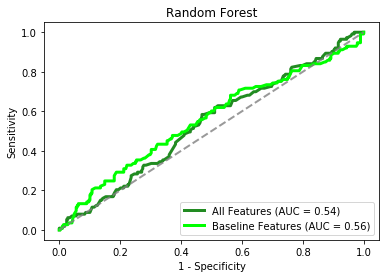

In [12]:
plt.plot(fpr_rf, tpr_rf, lw=3, alpha=1, color='forestgreen',
         label='All Features (AUC = %0.2f)' % auc_rf)
plt.plot(fpr_rfb, tpr_rfb, lw=3, alpha=1, color='lime',
         label='Baseline Features (AUC = %0.2f)' % auc_rfb)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey',
         alpha=.8)

# Define limits and labels
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.title("Random Forest")
plt.show()

In [13]:
sens_rf = tpr_rf[np.argmin(fpr_rf < 1 - spez)]
acc_rf  = (sens_rf * pos + spez * neg) / len(y)
print('AUC:', auc_rf)
print('Confidence Interval:', wilson_ci (auc_rf, len(y), 0.05))
print('Accuracy:', acc_rf)
print('Sensitivity:', sens_rf)
print('Specificity:', spez)

AUC: 0.5369192477876106
Confidence Interval: [0.488, 0.585]
Accuracy: 0.6713216957605985
Sensitivity: 0.08849557522123894
Specificity: 0.9


In [14]:
sens_rfb = tpr_rfb[np.argmin(fpr_rfb < 1 - spez)]
acc_rfb  = (sens_rfb * pos + spez * neg) / len(y)
print('AUC:', auc_rfb)
print('Confidence Interval:', wilson_ci (auc_rfb, len(y), 0.05))
print('Accuracy:', acc_rfb)
print('Sensitivity:', sens_rfb)
print('Specificity:', spez)

AUC: 0.5566463864306785
Confidence Interval: [0.508, 0.605]
Accuracy: 0.6887780548628428
Sensitivity: 0.1504424778761062
Specificity: 0.9


In [15]:
NeuralNetwork = MLPClassifier(solver='sgd', alpha=1e-5, max_iter = 10000,
                    hidden_layer_sizes=(5, 2), random_state=1)
grid_param_nn = {  
    'activation': ['logistic','tanh','relu'],
    'learning_rate': ['constant','invscaling'],
    'hidden_layer_sizes':[x for x in itertools.product((3,4,5),repeat=3)]
}

classifier_nn = GridSearchCV(estimator=NeuralNetwork, param_grid=grid_param_nn, cv=inner_cv, scoring='roc_auc')

In [16]:
probas_nn  = ravel(np.zeros(len(y)))
probas_nnb = ravel(np.zeros(len(y)))

for train, test in cv.split(X, y):
    fit = classifier_nn.fit(X[train], y[train])
    probs = fit.predict_proba(X[test])
    probas_nn[test] = probs[:, 1]
    fit = classifier_nn.fit(X1[train], y[train])
    probs = fit.predict_proba(X1[test])
    probas_nnb[test] = probs[:, 1]


In [17]:
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y, probas_nn)
auc_nn = auc(fpr_nn, tpr_nn)

fpr_nnb, tpr_nnb, thresholds_nnb = roc_curve(y, probas_nnb)
auc_nnb = auc(fpr_nnb, tpr_nnb)

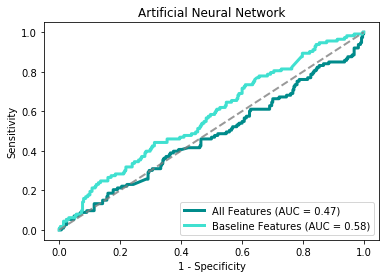

In [18]:
plt.plot(fpr_nn, tpr_nn, lw=3, alpha=1, color='darkcyan',
         label='All Features (AUC = %0.2f)' % auc_nn)
plt.plot(fpr_nnb, tpr_nnb, lw=3, alpha=1, color='turquoise',
         label='Baseline Features (AUC = %0.2f)' % auc_nnb)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey',
         alpha=.8)

# Define limits and labels
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.title("Artificial Neural Network")
plt.show()


In [19]:
sens_nn = tpr_nn[np.argmin(fpr_nn < 1 - spez)]
acc_nn  = (sens_nn * pos + spez * neg) / len(y)
print('AUC:', auc_nn)
print('Confidence Interval:', wilson_ci (auc_nn, len(y), 0.05))
print('Accuracy:', acc_nn)
print('Sensitivity:', sens_nn)
print('Specificity:', spez)

AUC: 0.4737278761061947
Confidence Interval: [0.425, 0.523]
Accuracy: 0.6738154613466334
Sensitivity: 0.09734513274336283
Specificity: 0.9


In [20]:
sens_nnb = tpr_nnb[np.argmin(fpr_nnb < 1 - spez)]
acc_nnb  = (sens_nnb * pos + spez * neg) / len(y)
print('AUC:', auc_nnb)
print('Confidence Interval:', wilson_ci (auc_nnb, len(y), 0.05))
print('Accuracy:', acc_nnb)
print('Sensitivity:', sens_nnb)
print('Specificity:', spez)

AUC: 0.5756206981317601
Confidence Interval: [0.527, 0.623]
Accuracy: 0.6962593516209477
Sensitivity: 0.17699115044247787
Specificity: 0.9


In [21]:
from sklearn import svm, datasets
svc = svm.SVC(probability = True)

grid_param_svm = {'kernel':('linear', 'rbf'), 'C':[1, 10], 'gamma':[.0001, .001, .01]}

classifier_svm = GridSearchCV(estimator=svc, param_grid=grid_param_svm, cv=inner_cv, scoring='roc_auc')

In [22]:
probas_svm  = ravel(np.zeros(len(y)))
probas_svmb = ravel(np.zeros(len(y)))

for train, test in cv.split(X, y):
    fit = classifier_svm.fit(X[train], y[train])
    probs = fit.predict_proba(X[test])
    probas_svm[test] = probs[:, 1]
    fit = classifier_svm.fit(X1[train], y[train])
    probs = fit.predict_proba(X1[test])
    probas_svmb[test] = probs[:, 1]

    
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y, probas_svm)
auc_svm = auc(fpr_svm, tpr_svm)

fpr_svmb, tpr_svmb, thresholds_svmb = roc_curve(y, probas_svmb)
auc_svmb = auc(fpr_svmb, tpr_svmb)

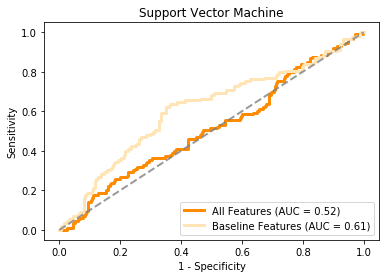

In [23]:
plt.plot(fpr_svm, tpr_svm, lw=3, alpha=1, color='darkorange',
         label='All Features (AUC = %0.2f)' % auc_svm)
plt.plot(fpr_svmb, tpr_svmb, lw=3, alpha=1, color='moccasin',
         label='Baseline Features (AUC = %0.2f)' % auc_svmb)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey',
         alpha=.8)

# Define limits and labels
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.title("Support Vector Machine")
plt.show()

In [24]:
sens_svm = tpr_svm[np.argmin(fpr_svm < 1 - spez)]
acc_svm  = (sens_svm * pos + spez * neg) / len(y)
print('AUC:', auc_svm)
print('Confidence Interval:', wilson_ci (auc_svm, len(y), 0.05))
print('Accuracy:', acc_svm)
print('Sensitivity:', sens_svm)
print('Specificity:', spez)

AUC: 0.5154867256637168
Confidence Interval: [0.467, 0.564]
Accuracy: 0.686284289276808
Sensitivity: 0.1415929203539823
Specificity: 0.9


In [25]:
sens_svmb = tpr_svmb[np.argmin(fpr_svmb < 1 - spez)]
acc_svmb  = (sens_svmb * pos + spez * neg) / len(y)
print('AUC:', auc_svmb)
print('Confidence Interval:', wilson_ci (auc_svmb, len(y), 0.05))
print('Accuracy:', acc_svmb)
print('Sensitivity:', sens_svmb)
print('Specificity:', spez)

AUC: 0.6121865781710915
Confidence Interval: [0.564, 0.659]
Accuracy: 0.6987531172069825
Sensitivity: 0.18584070796460178
Specificity: 0.9
